
#  Sentiment analysis  on Rotten Tomatoes Dataset using NLP

## Project goal
The Rotten tomatoes Data set is a movie reviews dataset. The goal of the project to perform sentimental analysis on critics reviews for different movies. 


In [6]:
# Down loaded all necessary packages
import csv
import os,re,csv
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim import corpora, models
import gensim
import numpy as np
import scipy
import math
import matplotlib.pyplot as plt 
import chart_studio.plotly as py
import twitter
import json
import seaborn as sns

ModuleNotFoundError: No module named 'stop_words'

## Data Extraction

Data set Extracted from Kaggle.Data set contains 156,060 records with 4 variables includes phrase id, sentence id, phrase, sentiment. There are 5 sentiments.
0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 – positive. 
Data set does not contain any null values.

In [7]:
# Imported the Required libraries
import nltk # Imports the library
nltk.download("all") #Download the necessary datasets

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/sravanthi/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/sravanthi/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /Users/sravanthi/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     /Users/sravanthi/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /Users/sravanthi/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     /Users/sravanthi/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    

KeyboardInterrupt: 

In [ ]:
#imported data set from kaggle
import pandas as pd
rot = pd.read_csv('/Users/sravanthi/Downloads/train.csv')
rot.head()

In [ ]:
#dataset structure
rot.info()

In [ ]:
#summary of the dataset
rot.describe()

## Data Cleaning
 
The datset looks clean but just to avoid future risk. 
I cleaned
1. Special characters
2. Changed upper case letters to lower case letters.
3. Created a column with text length for further Data Exploration.

In [ ]:
# cleaning the data by removing special characters changing the text lower characters
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df
rot = standardize_text(rot, "Phrase")

rot.to_csv("clean_data.csv")
rot.head()

## Data Visualization

1. Plotted bar chart for counting reviews for each sentiment. There class is very imbalanced. only sentiment 2 ( Neutral) has more number of reviews. o(negative) and 4(positive) are very low.

2. Plotted box plot to check different sentiments and the word length. Neutral statement text length is less than 50 compared to others. all others having text length more than 50

3. Number of words total count is 1074530 , with a vocabulary size of 15277
Max sentence length is 48

4. plotted heat map to Check the correlation between text length and sentiment. There is correlation between them.

5.plotted histograms to see whether length of all the words.most of the reviews length is less than 10 characters length.

6. tokenised the words and removed the stop words.then plotted wordblob to see most frequent words for each sentiment. there is nbo much difference between each sentiment.


In [ ]:
#  barplot to inspect sentiment
# most of them are neutral(2) ratings and second is average(3) rating movies
sns.countplot(rot['Sentiment'])

In [ ]:
# text length
# checking the length of the text for each phrase
rot['text_length'] = rot['Phrase'].apply(len)
rot[['Sentiment','text_length','Phrase']].head()

In [ ]:
#length of the text summary
# it looks average length of the text is 40. but the median is 26
rot['text_length'].describe()

In [ ]:
#distribution of text length
rot['text_length'].hist(bins=50)

In [ ]:
# distribution of the text length for each sentiment
# it looks most of the neutral (2) sentiment are very less in length but the 0 and 4 has  high lenth
g = sns.FacetGrid(rot,col='Sentiment')
g.map(plt.hist,'text_length')

In [ ]:
rot['Phrase'][0]

In [ ]:
# box plot for text length vs sentiment
sns.boxplot(x='Sentiment',y='text_length',data=rot,palette='rainbow')

In [ ]:
# checking correlarion between  sentiment and text length
# it looks there no correlation
sns.heatmap(rot[['Sentiment','text_length']].corr(), annot = True, cmap='coolwarm')

In [16]:
#Tokenize the phrase with comma(,) with tokenizer
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

rot["tokens"] = rot["Phrase"].apply(tokenizer.tokenize)
rot.head()

,PhraseId,SentenceId,Phrase,Sentiment,text_length,tokens
0,1,1,a series of escapades demonstrating the adage ...,1,188,"[a, series, of, escapades, demonstrating, the,..."
1,2,1,a series of escapades demonstrating the adage ...,2,77,"[a, series, of, escapades, demonstrating, the,..."
2,3,1,a series,2,8,"[a, series]"
3,4,1,a,2,1,[a]
4,5,1,series,2,6,[series]


In [17]:
# with the keras trying to find the total words and vocabulary
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in rot["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in rot["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

Using TensorFlow backend.
/Users/sravanthi/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/sravanthi/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/sravanthi/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/sravanthi/anaconda3/lib/python3.7/sit

1074530 words total, with a vocabulary size of 15277
Max sentence length is 48


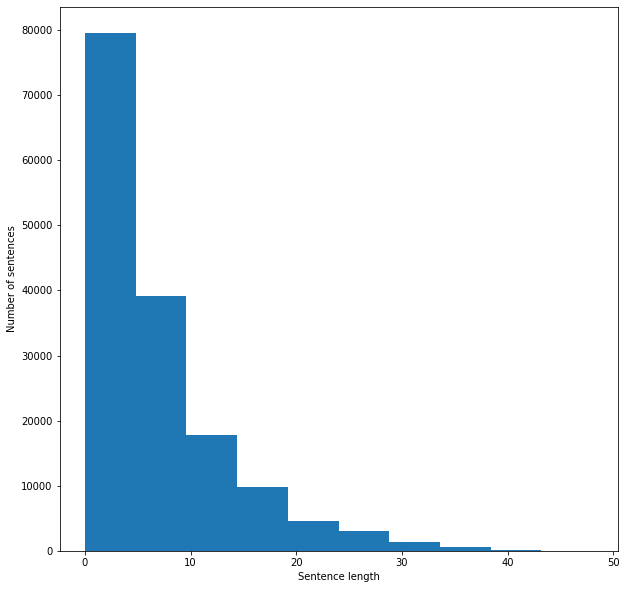

In [18]:
# Histogram for sentense length 
# most of the sentences having less than 10 length
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

In [3]:

# By removing the stop words applied wordcloud
# # word blob for sentiment 0
from nltk.corpus import stopwords
from wordcloud import WordCloud
from wordcloud import WordCloud, ImageColorGenerator
text = '.'.join(list(rot[rot.Sentiment ==0].Phrase))
wordcloud = WordCloud(stopwords=set(stopwords.words("english")),background_color="black").generate(text)
plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


NameError: name 'rot' is not defined

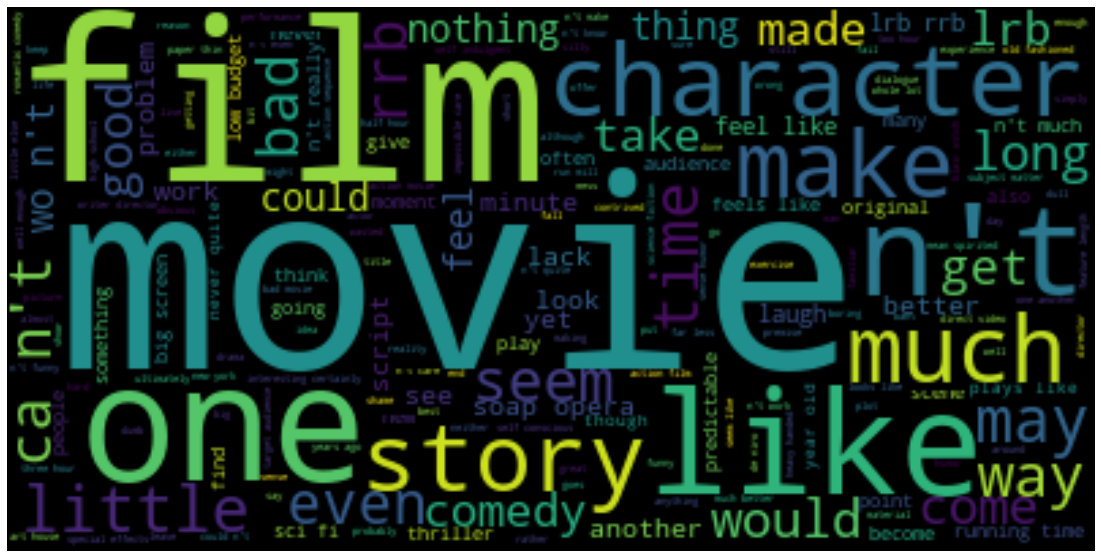

In [22]:
# word blob for sentiment 1
from wordcloud import WordCloud, ImageColorGenerator
text = '.'.join(list(rot[rot.Sentiment ==1].Phrase))
wordcloud = WordCloud(stopwords=set(stopwords.words("english")),background_color="black").generate(text)
plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

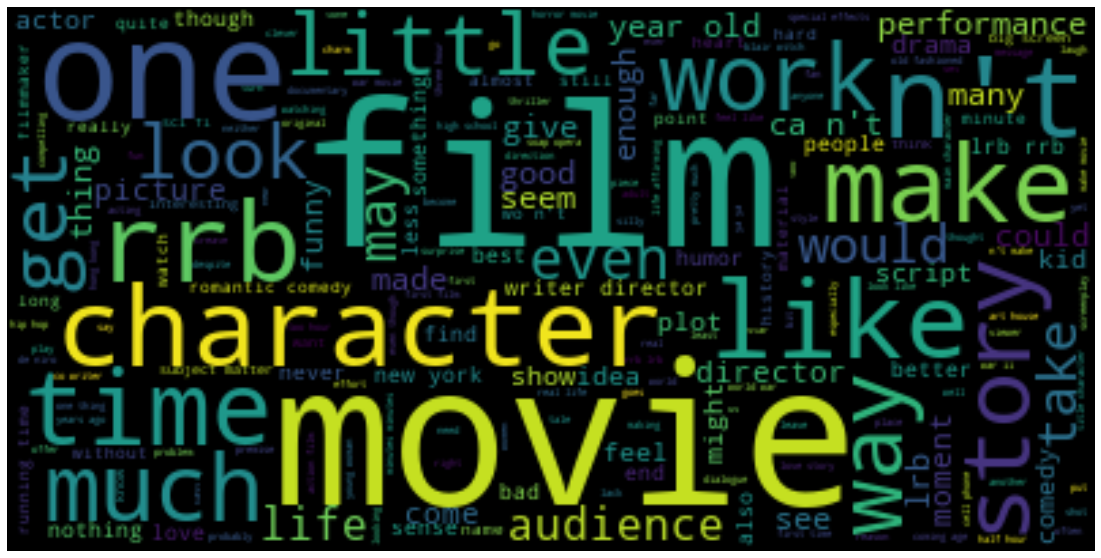

In [24]:
from wordcloud import WordCloud, ImageColorGenerator
text = '.'.join(list(rot[rot.Sentiment ==2].Phrase))
wordcloud = WordCloud(stopwords=set(stopwords.words("english")),background_color="black").generate(text)
plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

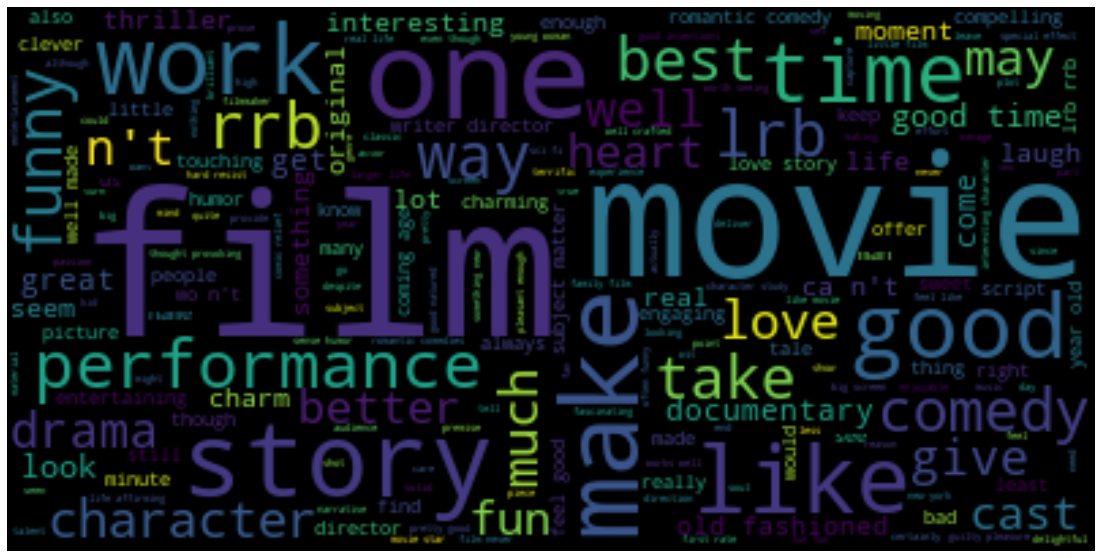

In [25]:
from wordcloud import WordCloud, ImageColorGenerator
text = '.'.join(list(rot[rot.Sentiment ==3].Phrase))
wordcloud = WordCloud(stopwords=set(stopwords.words("english")),background_color="black").generate(text)
plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

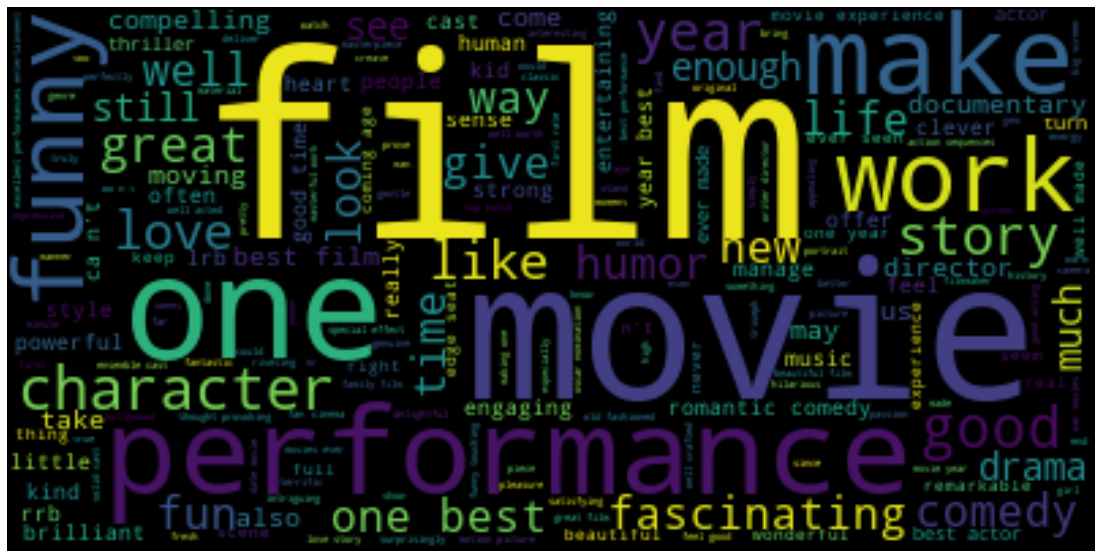

In [26]:
from wordcloud import WordCloud, ImageColorGenerator
text = '.'.join(list(rot[rot.Sentiment ==4].Phrase))
wordcloud = WordCloud(stopwords=set(stopwords.words("english")),background_color="black").generate(text)
plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

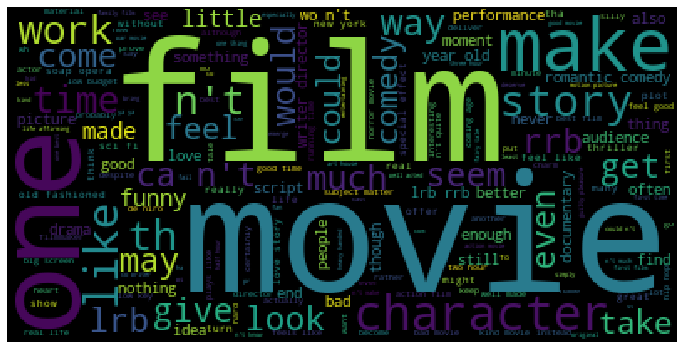

In [23]:
# By removing the stop words applied wordcloud
#  word blob for all sentiments
from nltk.corpus import stopwords
from wordcloud import WordCloud

text = rot['Phrase'].to_string()
wordcloud = WordCloud(
        relative_scaling=0.5,
        stopwords=set(stopwords.words('english'))).generate(text)

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Splitting the data  and Model building

### Bag Of Words.

1. Processed the data with count vectorizer to convert it into bag of words. bag of words converts the dataset in a table format with all unique word as variables for the dataset. where the frequency of words is counted from each line of text and stored with respective location of the dataset. It is kind of one hot encoding but if the same word repeated twice then the respective location value become 2. In bag of words concept which ever word repeated more is the most important word.


2. splitted the total data into 80% train and 20 % test.Then i trained the logistic regression model with 80%  train data and tested the model with 20 %  test data. With logistic regression i got 

Accuracy =  59.6%
Precision =  63.2%
Recall =  59.6%
F1 score = 60.7%

3. I repeated the same procedure with Random forest classification i got
 
Accuracy =  62.3%
Precision =  61.0%
Recall =  62.3%
F1 score = 61.4%
 
"BAG OF WORDS" with Random forest classification the precision decreased and recall increased. The average of it is F1 score it increased a bit compared to logistic regression.


$.Because it is quiet imbalanced data with more neutral sentiments(2). The precision and accuracy for 2 sentiment  is high compared to all. 

In [27]:
# splitted the data
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = rot["Phrase"].tolist()
list_labels = rot["Sentiment"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)


In [28]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [29]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f\n, precision = %.3f\n, recall = %.3f\n, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.596
, precision = 0.632
, recall = 0.596
, f1 = 0.607


In [31]:
print(classification_report(y_test, y_predicted_counts))

              precision    recall  f1-score   support

           0       0.36      0.59      0.45      1466
           1       0.47      0.53      0.50      5443
           2       0.79      0.65      0.72     16006
           3       0.50      0.51      0.50      6450
           4       0.39      0.62      0.48      1847

    accuracy                           0.60     31212
   macro avg       0.50      0.58      0.53     31212
weighted avg       0.63      0.60      0.61     31212



In [32]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt


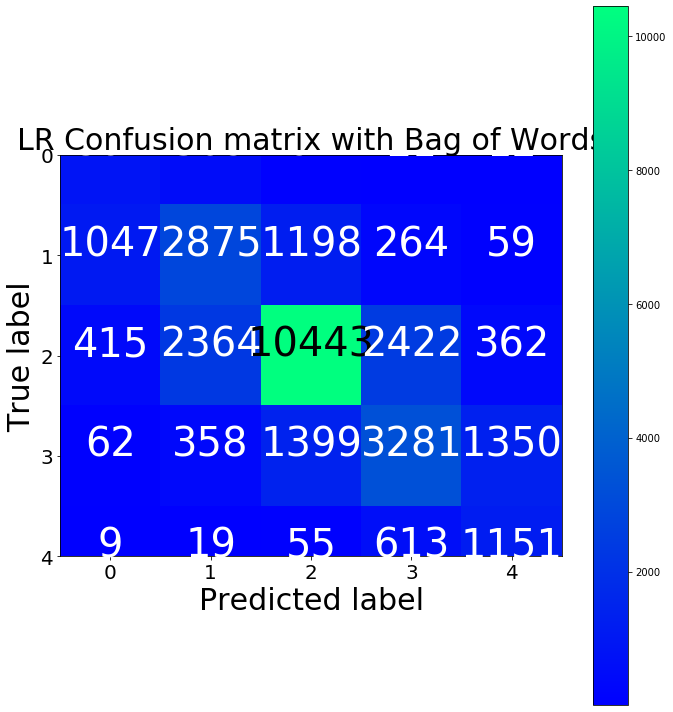

[[  862   509    62    21    12]
 [ 1047  2875  1198   264    59]
 [  415  2364 10443  2422   362]
 [   62   358  1399  3281  1350]
 [    9    19    55   613  1151]]


In [33]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['0','1','2','3','4'], normalize=False, title='LR Confusion matrix with Bag of Words')
plt.show()
print(cm)


In [35]:
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
#imporing the randomforest classifier from sklearn ensemble.
import sklearn
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier


In [36]:
# random forest model creation
rfc = RandomForestClassifier()
# training the model
rfc.fit(X_train_counts, y_train)
# predictions
rfc_predict_counts = rfc.predict(X_test_counts)
accuracy_score(y_test,rfc_predict_counts)


accuracy_counts, precision_counts, recall_counts, f1_counts = get_metrics(y_test,rfc_predict_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_counts, precision_counts, 
                                                                       recall_counts, f1_counts))



/Users/sravanthi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy = 0.618, precision = 0.606, recall = 0.618, f1 = 0.610


In [37]:
print(classification_report(y_test,rfc_predict_counts))

              precision    recall  f1-score   support

           0       0.45      0.36      0.40      1466
           1       0.51      0.45      0.48      5443
           2       0.70      0.78      0.74     16006
           3       0.52      0.47      0.49      6450
           4       0.49      0.38      0.43      1847

    accuracy                           0.62     31212
   macro avg       0.53      0.49      0.51     31212
weighted avg       0.61      0.62      0.61     31212



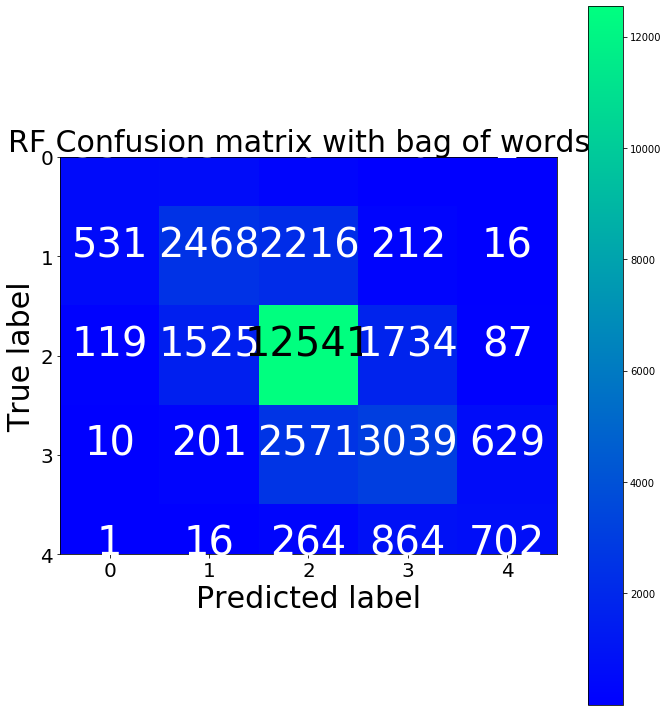

BoW confusion matrix with random forest
[[  534   637   267    26     2]
 [  531  2468  2216   212    16]
 [  119  1525 12541  1734    87]
 [   10   201  2571  3039   629]
 [    1    16   264   864   702]]


In [38]:
cm = confusion_matrix(y_test, rfc_predict_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['0','1','2','3','4'], normalize=False, title='RF Confusion matrix with bag of words  ')
plt.show()
print("BoW confusion matrix with random forest")
print(cm)


##  Model building with TF/IDF

### TF/IDF

1. Processed the data with TF/IDF. TF/IDF is short hand for term frequency and inverse document frequency. It converts the dataset into another datset with unique words as variables. Term frequency (tf) is basically the output of the BoW model.For a specific sentence, it determines how important a word is by looking at how frequently it appears in the sentence. Term frequency measures the local importance of the word.The second component of tf-idf is inverse document frequency (idf). For a word to be considered a signature word of a sentence, it shouldn’t appear that often in the other sentences. Thus, a important word’s document frequency must be low, meaning its inverse document frequency must be high. 

The tf-idf is the product of these two frequencies. For a word to have high tf-idf in a sentence, it must appear a lot of times in said sentence and must be absent in the other sentences. then It must be a important word of the sentence.

2. splitted the total data into 80% train and 20 % test.Then i trained the logistic regression model with 80%  train data and tested the model with 20 %  test data. With logistic regression i got 

Accuracy = 59.3%  
Precision = 63.7%
Recall = 59.3%
F1 score = 60.6 %

3. I repeated the same procedure with Random forest classification i got
 
Accuracy =  62.4% 
Precision = 60.8%
Recall = 62.4%
F1 score = 61.1%

"TF/IDF" with Random forest classification the precision decreased and recall increased. The homonic mean of it is F1 score it increased a bit compared to logistic regression.


$.Because it is quiet imbalanced data with more neutral sentiments(2). The precision and accuracy for 2 sentiment  is high compared to all. 

In [39]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [40]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [41]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.593, precision = 0.637, recall = 0.593, f1 = 0.606


In [47]:
print(classification_report(y_test, y_predicted_tfidf))

              precision    recall  f1-score   support

           0       0.35      0.61      0.45      1466
           1       0.47      0.53      0.50      5443
           2       0.81      0.64      0.71     16006
           3       0.49      0.51      0.50      6450
           4       0.39      0.65      0.49      1847

    accuracy                           0.59     31212
   macro avg       0.50      0.59      0.53     31212
weighted avg       0.64      0.59      0.61     31212



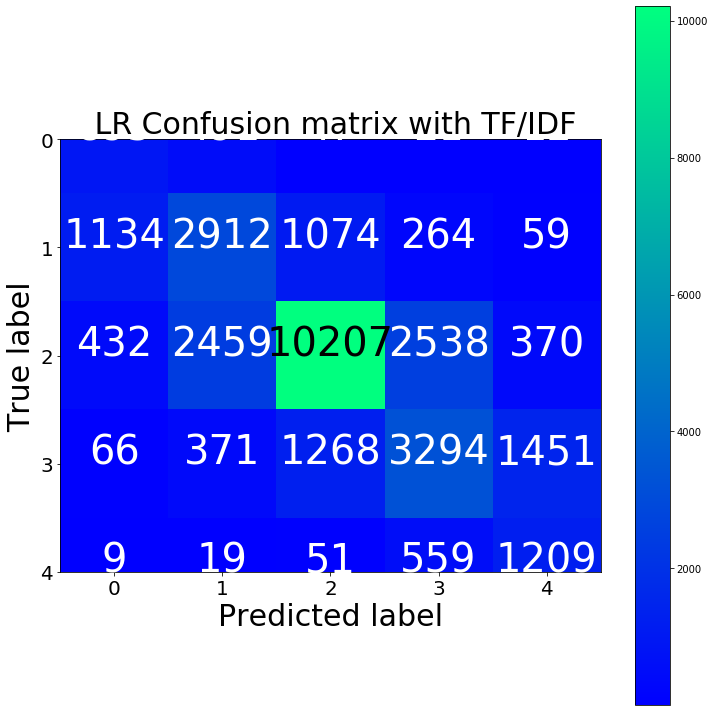

TFIDF confusion matrix
[[  895   491    47    21    12]
 [ 1134  2912  1074   264    59]
 [  432  2459 10207  2538   370]
 [   66   371  1268  3294  1451]
 [    9    19    51   559  1209]]


In [43]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['0','1','2','3','4'], normalize=False, title=' LR Confusion matrix with TF/IDF')
plt.show()
print("TFIDF confusion matrix")
print(cm2)


In [44]:
# random forest model creation
rfc = RandomForestClassifier()
# training the model
rfc.fit(X_train_tfidf, y_train)
# predictions
rfc_predict_tfidf = rfc.predict(X_test_tfidf)
accuracy_score(y_test,rfc_predict_tfidf)


accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, rfc_predict_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

/Users/sravanthi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy = 0.624, precision = 0.609, recall = 0.624, f1 = 0.612


In [48]:
print(classification_report(y_test, rfc_predict_tfidf))

              precision    recall  f1-score   support

           0       0.45      0.36      0.40      1466
           1       0.52      0.43      0.47      5443
           2       0.69      0.81      0.75     16006
           3       0.55      0.45      0.49      6450
           4       0.51      0.37      0.43      1847

    accuracy                           0.62     31212
   macro avg       0.54      0.49      0.51     31212
weighted avg       0.61      0.62      0.61     31212



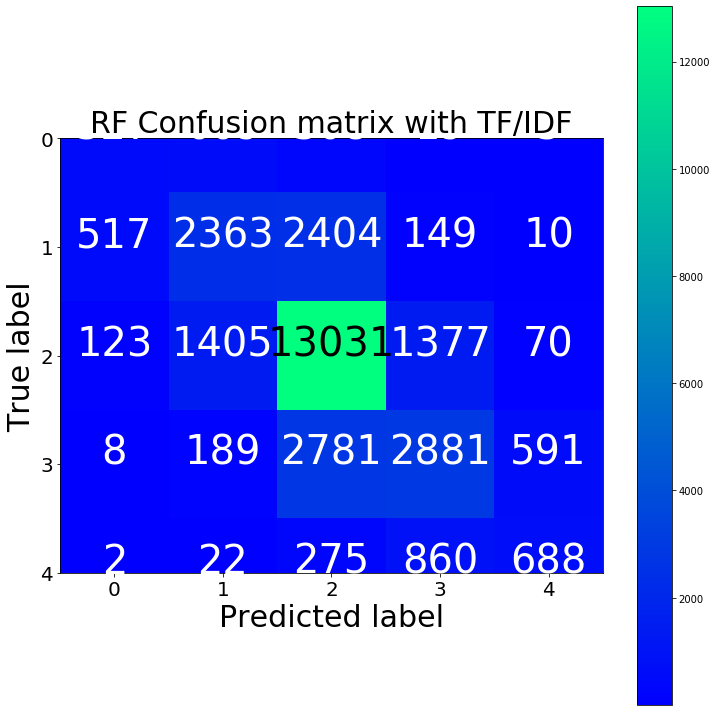

TFIDF confusion matrix
[[  527   609   308    19     3]
 [  517  2363  2404   149    10]
 [  123  1405 13031  1377    70]
 [    8   189  2781  2881   591]
 [    2    22   275   860   688]]


In [56]:
cm2 = confusion_matrix(y_test, rfc_predict_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['0','1','2','3','4'], normalize=False, title='RF Confusion matrix with TF/IDF')
plt.show()
print("TFIDF confusion matrix")
print(cm2)


##  Model building with Word2Vec

### Word2Vec

1. Processed the data with Wor2vec. Word2vec converts the words into  300 dimension vectors. It is a prediction based word e,mbedding technique.The algorithm works in 2 ways one is CBOW and the other is Skip-gram. CBOW is a continuous bag of words that tries to find the context with a group of sentences (corpus). Skip-gram is opposite to CBOW, with a given context it tries to find the words. It takes the average of the all the words. so sometimes it will not give accurate results.


2. splitted the total data into 80% train and 20 % test.Then i trained the logistic regression model with 80%  train data and tested the model with 20 %  test data. With logistic regression i got 

Accuracy = 44.4%  
Precision = 53.8%
Recall = 44.4%
F1 score = 46.9%

3. I repeated the same procedure with Random forest classification i got
 
Accuracy = 59.5%
Precision = 57.3%
Recall = 59.5%
F1 score = 57.5%

"Word2Vec" with Random forest classification the precision, recall, accuracy,f1 score increased alot compared to logistic regression.


$.Because it is quiet imbalanced data with more neutral sentiments(2). The precision and accuracy for 2 sentiment  is high compared to all. 

In [46]:
import gensim

# Load Google's pre-trained Word2Vec model.
word2vec = gensim.models.KeyedVectors.load_word2vec_format('/Users/sravanthi/Downloads/GoogleNews-vectors-negative300.bin', binary=True)  

In [49]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, rot, generate_missing=False):
    embeddings = rot['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [50]:
embeddings = get_word2vec_embeddings(word2vec, rot)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

In [51]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [52]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))


accuracy = 0.444, precision = 0.538, recall = 0.444, f1 = 0.469


In [53]:
print(classification_report(y_test_word2vec, y_predicted_word2vec))

              precision    recall  f1-score   support

           0       0.17      0.54      0.26      1466
           1       0.38      0.37      0.38      5443
           2       0.71      0.47      0.57     16006
           3       0.42      0.37      0.39      6450
           4       0.22      0.60      0.32      1847

    accuracy                           0.44     31212
   macro avg       0.38      0.47      0.38     31212
weighted avg       0.54      0.44      0.47     31212



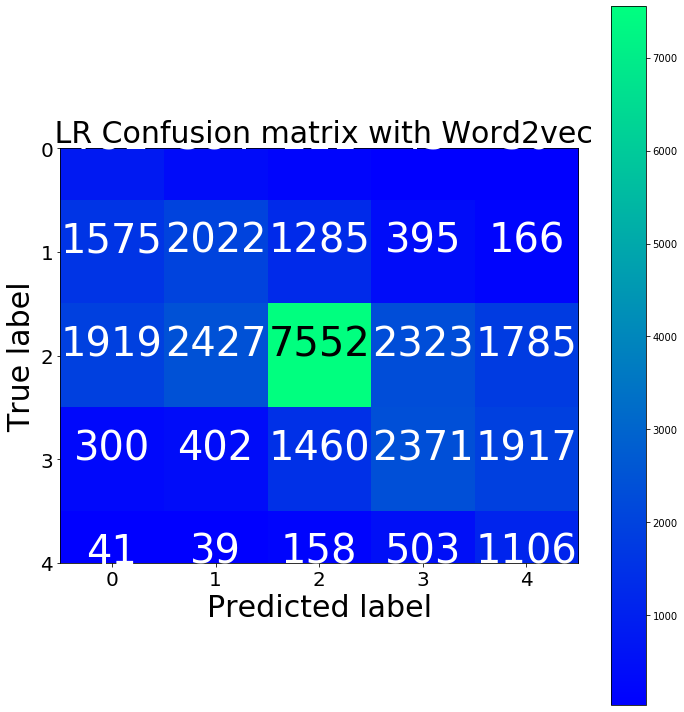

Word2Vec confusion matrix
[[ 792  384  211   43   36]
 [1575 2022 1285  395  166]
 [1919 2427 7552 2323 1785]
 [ 300  402 1460 2371 1917]
 [  41   39  158  503 1106]]


In [55]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm_w2v, classes=['0','1','2','3','4'], normalize=False, title=' LR Confusion matrix with Word2vec')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)


In [57]:
#imporing the randomforest classifier from sklearn ensemble.
import sklearn
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
# random forest model creation
rfc = RandomForestClassifier()
# training the model
rfc.fit(X_train_word2vec,y_train_word2vec)
# predictions
rfc_predict = rfc.predict(X_test_word2vec)
accuracy_score(y_test_word2vec,rfc_predict)

/Users/sravanthi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.59480328078944

In [58]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, rfc_predict)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))


accuracy = 0.595, precision = 0.574, recall = 0.595, f1 = 0.575


In [59]:
print(classification_report(y_test_word2vec, rfc_predict))

              precision    recall  f1-score   support

           0       0.45      0.26      0.33      1466
           1       0.44      0.38      0.41      5443
           2       0.66      0.82      0.73     16006
           3       0.51      0.40      0.45      6450
           4       0.52      0.28      0.37      1847

    accuracy                           0.59     31212
   macro avg       0.52      0.43      0.46     31212
weighted avg       0.57      0.59      0.58     31212



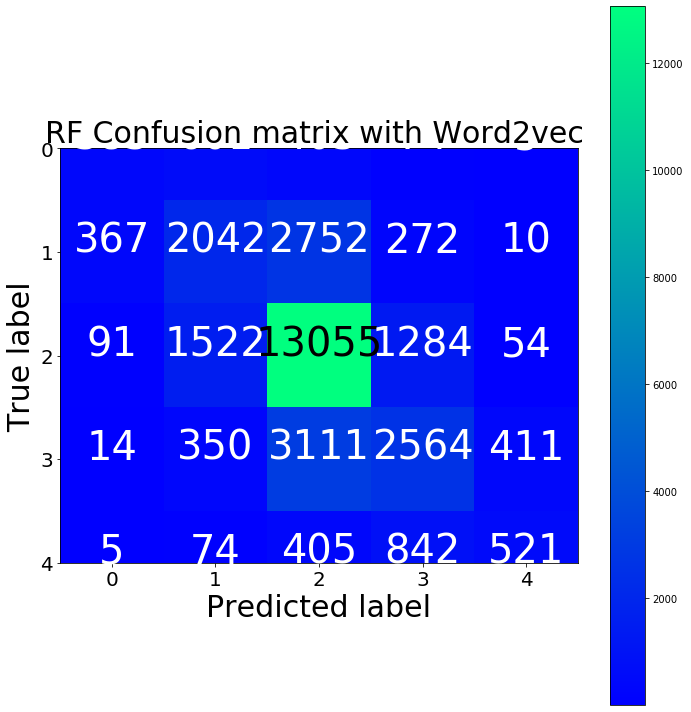

Word2Vec confusion matrix
[[  383   601   403    74     5]
 [  367  2042  2752   272    10]
 [   91  1522 13055  1284    54]
 [   14   350  3111  2564   411]
 [    5    74   405   842   521]]


In [62]:
cm_w2v = confusion_matrix(y_test_word2vec, rfc_predict)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm_w2v, classes=['0','1','2','3','4'], normalize=False, title='RF Confusion matrix with Word2vec ')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)


## Conclusion 

The sentimetal analysis on Rotten Tomatoes Dataset has given intresting results. As the dataset is an imbalanced class dataset, the major class (2 sentiment) predictions are better compared to all class with both logistic rtegression and  random forest classification. Thefrequency based word embedding techniques "Bag of Words" and "Tf/Idf" with random forest classification gave better predictions compared to all other methods.Overall the predictions with Random forest classification are better compared to logistic regression.


## Next Steps

1.Change the target variable from multi class to binary class classification would give better results.
                                        OR
  balance the class using different sampling techinques like over sampling or under sampling would give better results.
  
2. By traning the data to Neural Neural networks learns well from training dataset. so it might give better predictions.

